<a href="https://colab.research.google.com/github/SoltanReza/classification/blob/main/ProjetML2_2024_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Prérequis

### Installation

In [41]:
# pour monter son drive Google Drive local
from google.colab import drive
drive.mount('/content/gdrive')
import sys
my_local_drive='/content/gdrive/My Drive/Colab Notebooks/ML_FDS'
# Ajout du path pour les librairies, fonctions et données
sys.path.append(my_local_drive)
# Se positionner sur le répertoire associé
%cd $my_local_drive

%pwd


!pip install umap-learn[plot]
!pip install holoviews
!pip install  ipykernel

# eventuellement ne pas oublier de relancer le kernel du notebook
# !pip install tensorflow==2.17.0

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Colab Notebooks/ML_FDS


In [42]:
# Importation des différentes librairies utiles pour le notebook

#Sickit learn met régulièrement à jour des versions et
#indique des futurs warnings.
#ces deux lignes permettent de ne pas les afficher.
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# librairies générales
import pickle
import pandas as pd
from scipy.stats import randint
import numpy as np
import string
import time
import base64
import re
import sys
import copy
import random
from numpy import mean
from numpy import std

from google.colab import auth
import google.auth

# librairie affichage
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import plotly.graph_objs as go
import plotly.offline as py

from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# TensorFlow et keras
import tensorflow as tf
from keras import layers
from keras import models
from keras import optimizers
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img
from keras.callbacks import ModelCheckpoint, EarlyStopping
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing import image
from tqdm import tqdm
from keras.models import load_model
from sklearn.model_selection import KFold
from keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
import os
from os import listdir
from os.path import isfile, join
import cv2
import glob
from google.colab import auth
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload, MediaFileUpload
import io
import tempfile

### Utils

In [43]:
# afficher les res de train avec des plots ( version améliorée)
def plot_curves_confusion (history,confusion_matrix,class_names):
  plt.figure(1,figsize=(16,6))
  plt.gcf().subplots_adjust(left = 0.125, bottom = 0.2, right = 1,
                          top = 0.9, wspace = 0.25, hspace = 0)

  # division de la fenêtre graphique en 1 ligne, 3 colonnes,
  # graphique en position 1 - loss fonction

  plt.subplot(1,3,1)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['Training loss', 'Validation loss'], loc='upper left')
  # graphique en position 2 - accuracy
  plt.subplot(1,3,2)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['Training accuracy', 'Validation accuracy'], loc='upper left')

  # matrice de correlation
  plt.subplot(1,3,3)
  sns.heatmap(confusion_matrix,annot=True,fmt="d",cmap='Blues',xticklabels=class_names, yticklabels=class_names)# label=class_names)
  # labels, title and ticks
  plt.xlabel('Predicted', fontsize=12)
  #plt.set_label_position('top')
  #plt.set_ticklabels(class_names, fontsize = 8)
  #plt.tick_top()
  plt.title("Correlation matrix")
  plt.ylabel('True', fontsize=12)
  #plt.set_ticklabels(class_names, fontsize = 8)
  plt.show()



def plot_curves(histories):
    plt.figure(1,figsize=(16,6))
    plt.gcf().subplots_adjust(left = 0.125, bottom = 0.2, right = 1,
                          top = 0.9, wspace = 0.25, hspace = 0)
    for i in range(len(histories)):
    	# plot loss
    	plt.subplot(121)
    	plt.title('Cross Entropy Loss')
    	plt.plot(histories[i].history['loss'], color='blue', label='train')
    	plt.plot(histories[i].history['val_loss'], color='red', label='test')
    	plt.ylabel('loss')
    	plt.xlabel('epoch')
    	plt.legend(['Training loss', 'Validation loss'], loc='upper left')
    	# plot accuracy
    	plt.subplot(122)
    	plt.title('Classification Accuracy')
    	plt.ylabel('accuracy')
    	plt.xlabel('epoch')
    	plt.plot(histories[i].history['accuracy'], color='blue', label='train')
    	plt.plot(histories[i].history['val_accuracy'], color='red',
                 label='test')
    	plt.legend(['Training accuracy', 'Validation accuracy'], loc='upper left')
    plt.show()

# les fonctionnes d'authentification et enregistrer les résultat dans fichier csv
def authenticate_google_drive():
    """Authenticate and return the Google Drive API service."""
    auth.authenticate_user()  # This handles the OAuth2 authentication for Google Colab

    # Build the Google Drive API client
    service = build('drive', 'v3')
    return service

def download_file_from_drive(file_id):
    """Download a file from Google Drive."""
    service = authenticate_google_drive()

    # Request the file's content
    request = service.files().export_media(fileId=file_id, mimeType='text/csv')
    fh = io.BytesIO()
    downloader = MediaIoBaseDownload(fh, request)

    done = False
    while done is False:
        status, done = downloader.next_chunk()

    fh.seek(0)
    return pd.read_csv(fh)

def upload_file_to_drive(file_id, file_path):
    """Upload the file to Google Drive after modification."""
    service = authenticate_google_drive()

    # Upload the modified file to Google Drive
    media = MediaFileUpload(file_path, mimetype='text/csv')
    updated_file = service.files().update(fileId=file_id, media_body=media).execute()

    print(f"File updated: {updated_file['name']}")

def append_train_results_to_csv(file_id, train_results):
    """Append new train results to an existing CSV file on Google Drive."""
    # Download the existing CSV file

    try:
        df = download_file_from_drive(file_id)
    except pd.errors.EmptyDataError:
        # If the file is empty, create an empty DataFrame with the correct columns
        column_names = list(train_results.keys())
        df = pd.DataFrame(columns=column_names)

    # Append the new results (train_results should be a dict)
    new_row = pd.DataFrame([train_results])
    df = pd.concat([df, new_row], ignore_index=True)

    # Save the modified DataFrame to a temporary file
    with tempfile.NamedTemporaryFile(delete=False, mode='w', newline='') as tmpfile:
        temp_path = tmpfile.name
        df.to_csv(temp_path, index=False)

    # Upload the modified CSV back to Google Drive
    upload_file_to_drive(file_id, temp_path)

### Les jeux de données


In [44]:
!wget https://www.lirmm.fr/~poncelet/Ressources/Tiger-Fox-Elephant.zip

--2025-01-31 00:22:36--  https://www.lirmm.fr/~poncelet/Ressources/Tiger-Fox-Elephant.zip
Resolving www.lirmm.fr (www.lirmm.fr)... 193.49.104.251
Connecting to www.lirmm.fr (www.lirmm.fr)|193.49.104.251|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7605545 (7.3M) [application/zip]
Saving to: ‘Tiger-Fox-Elephant.zip.11’

Tiger-Fox-Elephant. 100%[===================>]   7.25M  4.92MB/s    in 1.5s    

2025-01-31 00:22:39 (4.92 MB/s) - ‘Tiger-Fox-Elephant.zip.11’ saved [7605545/7605545]



In [45]:

import zipfile
#with zipfile.ZipFile("Tiger-Fox-Elephant.zip","r") as zip_ref:
    #zip_ref.extractall("Data_Project")

**Créer le jeu de données**

Actuellement pour chaque animal nous avons un répertoire qui contient des images positives et un répertoire qui contient des images négatives. Pour pouvoir créer un jeu de données nous devons obtenir X et y. Les fonctions ci-dessous permettent de générer, à partir des répertoires, un jeu de données aléatoire pour X et y.

In [46]:
def create_training_data(path_data, list_classes):
  training_data=[]
  for classes in list_classes:
      path=os.path.join(path_data, classes)
      class_num=list_classes.index(classes)
      for img in os.listdir(path):
        try:
          img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_UNCHANGED)
          new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
          training_data.append([new_array, class_num])
        except Exception as e:
          pass
  return training_data

def create_X_y (path_data, list_classes):
      # récupération des données
      training_data=create_training_data(path_data, list_classes)
      # tri des données
      random.shuffle(training_data)
      # création de X et y
      X=[]
      y=[]
      for features, label in training_data:
        X.append(features)
        y.append(label)
      X=np.array(X).reshape(-1,IMG_SIZE, IMG_SIZE, 3)
      y=np.array(y)
      return X,y

def plot_examples(X,y):
  plt.figure(figsize=(15,15))
  for i in range(COLUMNS):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    # cv2 lit met les images en BGR et matplotlib lit du RGB
    X[i] = cv2.cvtColor(X[i], cv2.COLOR_BGR2RGB)
    plt.imshow(X[i]/255.,cmap=plt.cm.binary)
    plt.xlabel('classe ' + str(y[i]))

## Train


### Preparations

Définition de constante globale      


In [47]:
# constantes globales

IMG_SIZE=128
COLUMNS = 25 # Nombre d'images à afficher
optimizer = 'adam'
activation='relu'
my_path="Data_Project/Tiger-Fox-Elephant/"
my_classes=['tiger','Tiger_negative_class']
batch_size=32
epochs=15

### Fameux Modèle

In [48]:


# Charger les données
X, y =create_X_y(my_path,my_classes)
X=X.astype('float')
X=X/255.0
# Diviser en ensembles d'entraînement, de validation, et de test
x_train, x_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

print(f"Train: {len(x_train)}, Validation: {len(x_val)}, Test: {len(x_test)}")

# === 2. Construire le modèle CNN ===
model = models.Sequential([
    # Première couche de convolution
    layers.Conv2D(32, (3, 3), activation=activation, input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D((2, 2)),

    # Deuxième couche de convolution
    layers.Conv2D(64, (3, 3), activation=activation),
    layers.MaxPooling2D((2, 2)),

    # Troisième couche de convolution
    layers.Conv2D(128, (3, 3), activation=activation),
    layers.MaxPooling2D((2, 2)),

    # Aplatir les données et ajouter les couches denses
    layers.Flatten(),
    layers.Dense(128, activation=activation),
    # layers.Dropout(0.5),  # Pour éviter le surapprentissage
    layers.Dense(1, activation='sigmoid')  # Sigmoïde pour classification binaire
])

# === 3. Compiler et entraîner le modèle ===
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',  # Perte pour la classification binaire
              metrics=['accuracy'])

print(model.summary())  # Résumé du modèle
start_time = time.time()

# Entraîner le modèle
history = model.fit(
    x_train, y_train,
    epochs=epochs,
    validation_data=(x_val, y_val),
    batch_size=batch_size
)
training_time = time.time() - start_time


Train: 139, Validation: 30, Test: 30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.4201 - loss: 1.1699 - val_accuracy: 0.5667 - val_loss: 0.6819
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5458 - loss: 0.6930 - val_accuracy: 0.4333 - val_loss: 0.6925
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.5840 - loss: 0.6875 - val_accuracy: 0.7667 - val_loss: 0.6787
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 684ms/step - accuracy: 0.6302 - loss: 0.6748 - val_accuracy: 0.6000 - val_loss: 0.6491
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 752ms/step - accuracy: 0.5041 - loss: 0.6665 - val_accuracy: 0.6000 - val_loss: 0.6333
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 681ms/step - accuracy: 0.5819 - loss: 0.6362 - val_accuracy: 0.7000 - val_loss: 0.5935
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 645ms/step - accuracy: 0.6301 - loss: 0.6123 - val_accuracy: 0.4333 - val_loss: 0.8017
Epoch 8/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 729ms/step - accuracy: 0.6532 - loss: 0.5876 - val_accuracy: 0.7000 - val_loss: 

### Évaluer les performances

In [49]:
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.7333 - loss: 0.7098
Test Accuracy: 73.33%


### Visualiser les résultat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


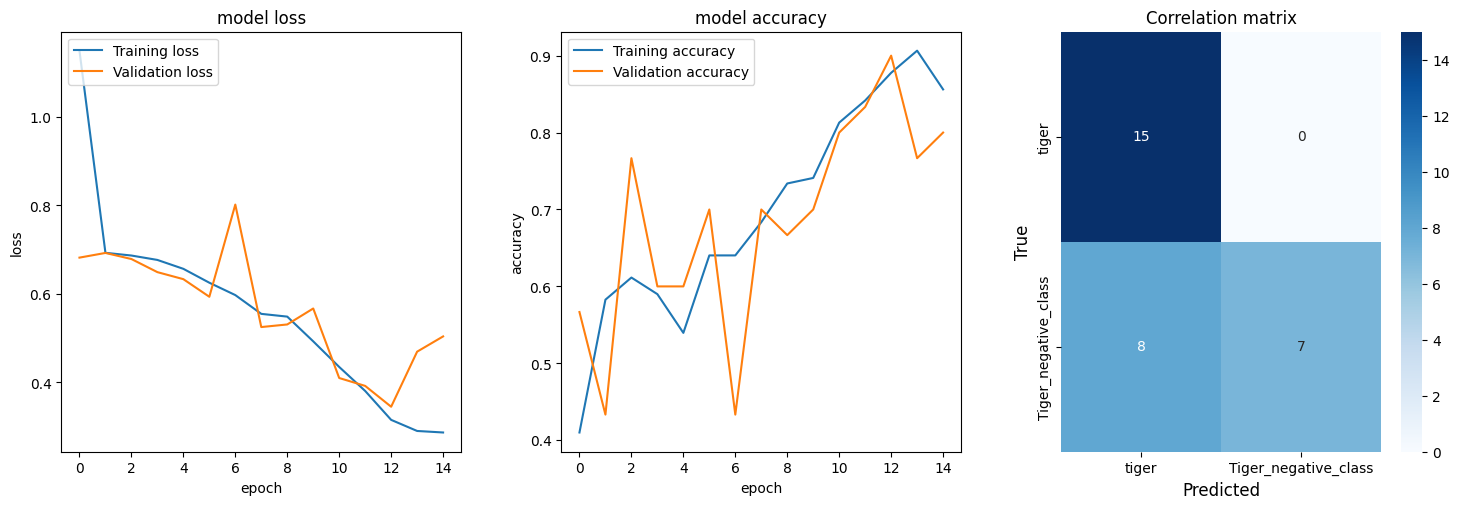

In [52]:

y_pred = model.predict(x_test)  # Sortie brute du modèle
y_pred_classes = []
for i in y_pred:
    for j in i:
      y_pred_classes.append ((j > 0.5).astype(int)) # Convert to class 0 or 1


cm = confusion_matrix(y_test , y_pred_classes)

plot_curves_confusion(history,cm,my_classes)

### Enregistrer les résultats

In [51]:


# Récupérer les résultats de l'entraînement
final_loss = history.history['loss'][-1]
final_accuracy = history.history['accuracy'][-1]
final_val_loss = history.history['val_loss'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]

# Scopes required to access and modify Google Drive files
SCOPES = ['https://www.googleapis.com/auth/drive.file']


# Example usage
file_id = '1sEaqLjJN7lZCKJ2fYbOmiqJIytB8wIpKChZkK32kzCI'  # Replace with your actual Google Drive file ID
# Remplir le template avec ces résultats
train_results = {
    'Training ID': time.strftime("%Y%m%d%H%M%S"),  # Timestamp comme ID d'entraînement
    'Model Name': 'CNN',  # Nom du modèle
    'Coach' : 'Reza',
    'Epoch': epochs,  # Nombre d'époques
    'Loss': final_loss,
    'Accuracy': final_accuracy,
    'Validation Loss': final_val_loss,
    'Validation Accuracy': final_val_accuracy,
    'Training Time (s)': training_time,
    'Batch size': batch_size,
    'Learning Rate': None,  # Exemples de valeurs pour le learning rate
    'Optimizer': optimizer,  # Optimiseur utilisé
    'Model Type': 'Sequential',  # Type de modèle
    'Dataset Type': 'Custom'  # Type de dataset
}

append_train_results_to_csv(file_id, train_results)


File updated: train_results
